# Optimum parameters $\tau$

In [4]:
# import API
import pwpp
from pwpp import *
from matplotlib import cm
import matplotlib.ticker as ticker
import pickle
filename='Optimum_tau'

In [5]:
# load
infile = open(filename,'rb')
Elst, E0lst, W0opt_th, Npopt_th = pickle.load(infile)
infile.close()

In [6]:
# parameters
# laser
lbd = 0.8; #[\mu m]
w0 = 2*pi*c/(lbd*1e-6)*hbar/e*1e-9; #[GeV]
W0lst = np.linspace(2.2,12,60); #[\mu m]
# beam
E0 = 13; #[GeV]
g0 = E0/m; #[]
sigmax = 24.4; #[\mu m]
sigmay = 29.6; #[\mu m]
R = (sigmax+sigmay)/2*sqrt(2); #[\mu m]
L = 200; #[\mu m]
nb = 1e16; #[cm^-3]
nb = nb * 1e-12; #[\mu m^-3]
Nb = nb*(pi*R**2*L); #[]

In [13]:
# W0opt(E)
Elst = np.linspace(100,1000,20)
taulst = np.linspace(30,200,15)

In [ ]:
W0opt_th = np.zeros((len(Elst),len(taulst)))
Npopt_th = np.zeros((len(Elst),len(taulst)))
for i in trange(len(Elst)):
    for j in range(len(taulst)):
        
        tau = taulst[j]; #[fs]
        n = tau*c/(lbd*1e-6)*1e-15; #[]
        
        E = Elst[i]; #[J]
        a0max = sqrt(E/tau/(2.149e-5))*(lbd/min(W0lst)); #[]
        
        # Interpolate N+
        amin = 1; #[]
        a0int = np.linspace(amin,a0max,200); #[]
        Npint = np.array([Np(g0, a, w0, n)[0] for a in a0int]); #[]
        Npinterp1d = interpolate.interp1d(a0int, Npint); #[]
        
        NpW0 = np.zeros(len(W0lst)); #[]
        for k in range(len(W0lst)):
            W0 = W0lst[k]; #[\mu m]
            a0 = sqrt(E/tau/(2.149e-5))*(lbd/W0); #[]

            # analytical distribution
            def dNda(a,a0,W0):
                """theory"""
                zR = pi*W0**2/lbd; #[\mu m]
                az = a0/sqrt(1+(L/4/zR)**2)
                return np.piecewise(a, [a > az, a <= az], [lambda a: 4*pi*nb*W0**2*zR/a * 1/3/a * sqrt(a0**2-a**2) * ((a0/a)**2+2),
                                                           lambda a: 4*pi*nb*W0**2*zR/a * L/4/zR * (1+(L/4/zR)**2/3) ])

            alst = np.linspace(amin,0.999*a0,300);
            dNp = Npinterp1d(alst);
            ddNda = dNda(alst,a0,W0);

            NpW0[k] = np.trapz(ddNda * dNp, alst)
        W0opt_th[i,j], Npopt_th[i,j] = W0lst[np.argmax(NpW0)], max(NpW0)

In [ ]:
# save
outfile = open(filename,'wb')
pickle.dump([Elst, taulst, W0opt_th, Npopt_th],outfile)
outfile.close()

In [ ]:
ratioarr = max(taulst)/max(Elst)
ratioplt = 1/2
ratioadj = 0.057

plt.style.use("style.txt")
fig, axes =  plt.subplots(nrows=1, ncols=2,figsize=(12,3.2))

def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

im0 = axes[0].imshow(W0opt_th.T, interpolation='bilinear', origin='lower', extent=[min(Elst), max(Elst), min(taulst), max(taulst)],aspect=ratioplt/ratioarr,
              vmax=np.max(W0opt_th), vmin=np.min(W0opt_th), cmap=cm.Blues_r)
axes[0].images.append(im0)
axes[0].set_xlabel(r'$\varepsilon[\mathrm{J}]$')
axes[0].set_ylabel(r'$\tau[\mathrm{fs}]$',labelpad=15)
axes[0].set_yticks([30,70,110,150,190])
axes[0].tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True, color='white')
axes[0].tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True, color='white')
cbar0 = fig.colorbar(im0, ax=axes[0],fraction=ratioadj*ratioarr/ratioplt, pad=0.02)
#cbar0.set_ticks([2,4,6,8,10])
cbar0.set_ticks([3,5,7,9,11])
cbar0.set_label(r'$W_0[\mu\mathrm{m}]$',labelpad=1,y=0.5)
#axes[0].set_aspect(aspect=4/3)

im1 = axes[1].imshow(Npopt_th.T*1e-9, interpolation='bilinear', origin='lower', extent=[min(Elst), max(Elst), min(taulst), max(taulst)],aspect=ratioplt/ratioarr,
              vmax=np.max(Npopt_th*1e-9), vmin=np.min(Npopt_th*1e-9), cmap=cm.Blues_r)
axes[1].images.append(im1)
axes[1].set_xlabel(r'$\varepsilon[\mathrm{J}]$')
axes[1].set_ylabel(r'$\tau[\mathrm{fs}]$',labelpad=15)
axes[1].set_yticks([30,70,110,150,190])
axes[1].tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True, color='white')
axes[1].tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True, color='white')
cbar1 = fig.colorbar(im1, ax=axes[1],fraction=ratioadj*ratioarr/ratioplt, pad=0.02)
cbar1.set_ticks([0.1,0.5,0.9,1.3])
cbar1.set_label(r'$\times 10^9 ~N_+ \left[ \frac{n_b}{10^{16}~ \mathrm{cm}^{-3}} \right]$',labelpad=10,y=0.5)
#axes[1].set_aspect(aspect=4/3)

plt.tight_layout()
#plt.savefig('epstau.pdf')
plt.show()

In [15]:
from scipy import interpolate
import matplotlib.colors as colors

# ELI
f = interpolate.interp2d(X, Y, W0opt_th, kind='linear')
print( f(1000,150) )
f = interpolate.interp2d(X, Y, Npopt_th, kind='linear')
print( f(1000,150) )

[6.17240571]
[2.43464441e+08]


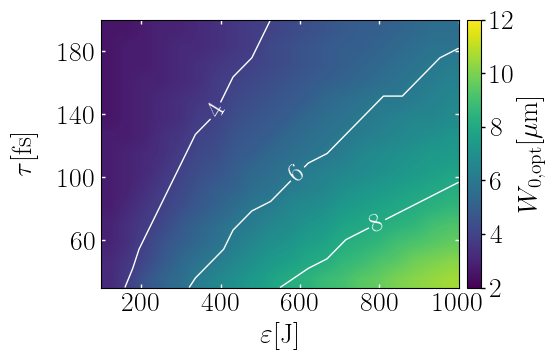

In [45]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

im0 = axes.imshow(W0opt_th.T, interpolation='bilinear', origin='lower', extent=[min(Elst), max(Elst), min(taulst), max(taulst)],
              vmax=12, vmin=2, cmap='viridis')
axes.images.append(im0)
axes.set_xlabel(r'$\varepsilon[\mathrm{J}]$')
axes.set_ylabel(r'$\tau[\mathrm{fs}]$',labelpad=15)
axes.tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True, color='white')
axes.tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True, color='white')
axes.set_xticks([200,400,600,800,1000])
axes.set_yticks([20,60,100,140,180])

X,Y=np.meshgrid(Elst,taulst)
fmt = {}
cplevels = [2,4,6,8,12]
strs = ['2','4','6','8','12']
for l, s in zip(cplevels, strs):
    fmt[l] = s
cp = axes.contour(X, Y, W0opt_th.T, cplevels, colors='white', linewidths=1.0)
manual_locations = [(400, 140), (600, 100), (780, 80)]
tmp1 = axes.clabel(cp, cplevels, inline = True, fmt = fmt, fontsize=20, colors='white',manual=manual_locations)

cbar0 = fig.colorbar(im0, ax=axes,fraction=0.1, pad=0.02)
cbar0.set_ticks([2,4,6,8,10,12])
cbar0.set_label(r'$W_{0,\mathrm{opt}}[\mu \mathrm{m}]$',labelpad=1,y=0.5)
# aspect
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
axes.set_aspect(aspect=3/4/axesratio)
# final
plt.tight_layout()
plt.savefig('Optimum_tau_a.pdf')
plt.show()

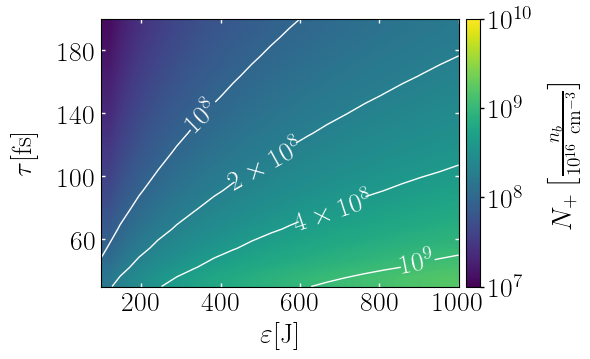

In [39]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

im1 = axes.imshow(Npopt_th.T, interpolation='bilinear', origin='lower', extent=[min(Elst), max(Elst), min(taulst), max(taulst)],
              norm=colors.LogNorm(vmax=1e10, vmin=1e7), cmap='viridis')
axes.images.append(im1)
axes.set_xlabel(r'$\varepsilon[\mathrm{J}]$')
axes.set_ylabel(r'$\tau[\mathrm{fs}]$',labelpad=15)
axes.tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True, color='white')
axes.tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True, color='white')
axes.set_xticks([200,400,600,800,1000])
axes.set_yticks([20,60,100,140,180])

X,Y=np.meshgrid(Elst,taulst)
fmt = {}
cplevels = [1e8,2e8,4e8,1e9]
strs = [r'$10^8$',r'$2\times10^8$',r'$4\times10^8$',r'$10^9$']
for l, s in zip(cplevels, strs): fmt[l] = s
cp = axes.contour(X, Y, Npopt_th.T, cplevels, colors='white', linewidths=1.0)
manual_locations = [(350, 140), (530, 100), (680, 80), (900,40)]
tmp1 = axes.clabel(cp, cplevels, inline = True, fmt = fmt, fontsize=20, colors='white',manual=manual_locations)

cbar1 = fig.colorbar(im1, ax=axes,fraction=0.05, pad=0.02)
cbar1.set_ticks([1e6,1e7,1e8,1e9,1e10])
cbar1.set_label(r'$N_+ \left[ \frac{n_b}{10^{16}~ \mathrm{cm}^{-3}} \right]$',labelpad=10,y=0.5)

# aspect
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
axes.set_aspect(aspect=3/4/axesratio)
# final
plt.tight_layout()
plt.savefig('Optimum_tau_b.pdf')
plt.show()